__Dataset Info:__ Dataset has been taken from https://www.kaggle.com/aungpyaeap/fish-market. Each data instance refers to a fish with corresponding length, species, height, width and weight information. The task is to infer a regressor from given features to weight info.

In [1]:
using CSV, MLDataUtils, LinearAlgebra, Distributions

In [2]:
dt = CSV.read("Datasets/Fish.csv") #Read in a dataframe

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read(::String) at CSV.jl:40
└ @ CSV /Users/sakbayrak/.julia/packages/CSV/MKemC/src/CSV.jl:40


159×7 DataFrame
│ Row │ Species │ Weight  │ Length1 │ Length2 │ Length3 │ Height  │ Width   │
│     │ String  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ Bream   │ 242.0   │ 23.2    │ 25.4    │ 30.0    │ 11.52   │ 4.02    │
│ 2   │ Bream   │ 290.0   │ 24.0    │ 26.3    │ 31.2    │ 12.48   │ 4.3056  │
│ 3   │ Bream   │ 340.0   │ 23.9    │ 26.5    │ 31.1    │ 12.3778 │ 4.6961  │
│ 4   │ Bream   │ 363.0   │ 26.3    │ 29.0    │ 33.5    │ 12.73   │ 4.4555  │
│ 5   │ Bream   │ 430.0   │ 26.5    │ 29.0    │ 34.0    │ 12.444  │ 5.134   │
│ 6   │ Bream   │ 450.0   │ 26.8    │ 29.7    │ 34.7    │ 13.6024 │ 4.9274  │
│ 7   │ Bream   │ 500.0   │ 26.8    │ 29.7    │ 34.5    │ 14.1795 │ 5.2785  │
│ 8   │ Bream   │ 390.0   │ 27.6    │ 30.0    │ 35.0    │ 12.67   │ 4.69    │
│ 9   │ Bream   │ 450.0   │ 27.6    │ 30.0    │ 35.1    │ 14.0049 │ 4.8438  │
│ 10  │ Bream   │ 500.0   │ 28.5    │ 30.7    │ 36.2    │ 14.2266 │ 4.9594  │
⋮
│ 149 │ Smelt   │ 9.7     │ 10.4    │ 11.0    │ 12.0    │ 2.196   │ 1.38    │
│ 150 │ Smelt   │ 9.8     │ 10.7    │ 11.2    │ 12.4    │ 2.0832  │ 1.2772  │
│ 151 │ Smelt   │ 8.7     │ 10.8    │ 11.3    │ 12.6    │ 1.9782  │ 1.2852  │
│ 152 │ Smelt   │ 10.0    │ 11.3    │ 11.8    │ 13.1    │ 2.2139  │ 1.2838  │
│ 153 │ Smelt   │ 9.9     │ 11.3    │ 11.8    │ 13.1    │ 2.2139  │ 1.1659  │
│ 154 │ Smelt   │ 9.8     │ 11.4    │ 12.0    │ 13.2    │ 2.2044  │ 1.1484  │
│ 155 │ Smelt   │ 12.2    │ 11.5    │ 12.2    │ 13.4    │ 2.0904  │ 1.3936  │
│ 156 │ Smelt   │ 13.4    │ 11.7    │ 12.4    │ 13.5    │ 2.43    │ 1.269   │
│ 157 │ Smelt   │ 12.2    │ 12.1    │ 13.0    │ 13.8    │ 2.277   │ 1.2558  │
│ 158 │ Smelt   │ 19.7    │ 13.2    │ 14.3    │ 15.2    │ 2.8728  │ 2.0672  │
│ 159 │ Smelt   │ 19.9    │ 13.8    │ 15.0    │ 16.2    │ 2.9322  │ 1.8792  │

# Preprocessing

In [3]:
Species_list = unique(dt["Species"]) #unique species

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:1
└ @ Core In[3]:1


7-element Array{String,1}:
 "Bream"    
 "Roach"    
 "Whitefish"
 "Parkki"   
 "Perch"    
 "Pike"     
 "Smelt"    

In [4]:
#Collect features in matrix and outputs in vector
X = zeros(length(dt[:,1]),7+5+1)
y = convert(Array, dt[:,2])

X[:,8:12] = convert(Matrix, dt[:,3:7])

for i=1:length(dt[:,1])
    species = dt[i,:]["Species"]
    X[i,findfirst(x -> x==species,Species_list)] = 1.0 #one-hot encoding for species
end

X[:,end] = ones(length(dt[:,1]))
;

In [66]:
# shuffle the data
Xs, Ys = shuffleobs((transpose(X), y))

# split the data into training sets and validation sets
(X_train, y_train), (X_test, y_test) = splitobs((Xs, Ys); at = 0.7)

X_train, X_test = transpose(X_train), transpose(X_test)
;

Note that target is positive real valued data. We standardize the target so that it will be convenient to define Normal likelihood on it

In [67]:
z_train = (y_train .- mean(y_train))./std(y_train);

# Maximum Likelihood Estimation

Loss = $\sum\limits_{i} (y_i - x_i^T b)^2 = (y-Xb)^T (y-Xb)$

$\frac{d Loss}{db} = 0 = -2 X^T y + 2 X^T X b => b = (X^T X)^{-1} X^T y$

In [68]:
# Note that finding the inverse of a matrix is costly.
# Therefore we use x=A\b which is an efficient way of finding x s.t. Ax=b satisfied
b = (transpose(X_train)*X_train)\(transpose(X_train)*z_train)

13-element Array{Float64,1}:
 -0.3367898466764326 
 -0.4498882671454514 
 -0.46258718532121373
 -0.21104125412427066
 -0.4920925858617683 
 -1.2630703028141395 
  0.30143697495617156
 -2.076660931410917  
  3.389081589696893  
 -0.18679385941992463
 -0.07270302251496026
  0.06025920672091977
  0.5200081462589949 

In [69]:
# Evaluate on test
z_estimate = X_test*b

# Inverse mapping
y_estimate = std(y_train).*z_estimate .+ mean(y_train)

#calculate mean squared error
mse = sum((y_test.-y_estimate).^2)/length(y_test)

8135.322803721276

In [70]:
# Quantitative comparisons
println("True test weights: ", y_test)
println("Estimated test weights: ", y_estimate)

True test weights: [900.0, 685.0, 700.0, 950.0, 345.0, 90.0, 770.0, 80.0, 690.0, 500.0, 363.0, 130.0, 78.0, 250.0, 225.0, 120.0, 850.0, 300.0, 955.0, 7.0, 475.0, 32.0, 9.9, 150.0, 13.4, 145.0, 514.0, 700.0, 110.0, 130.0, 567.0, 170.0, 300.0, 290.0, 9.7, 10.0, 115.0, 200.0, 145.0, 135.0, 160.0, 820.0, 1100.0, 1100.0, 650.0, 390.0, 500.0, 540.0]
Estimated test weights: [873.405, 623.99, 591.6, 900.119, 483.913, 46.0693, 875.451, 39.1253, 719.048, 754.752, 470.12, 180.933, 43.2249, 376.198, 225.541, 99.9599, 743.584, 443.441, 848.443, -58.7216, 526.816, -191.903, -21.5902, 202.267, 16.1711, 187.366, 570.585, 697.444, 170.582, 134.764, 770.211, 168.995, 361.278, 342.094, -36.7742, -20.0099, 124.176, 170.832, 129.52, 162.11, 142.686, 790.303, 967.6, 930.938, 787.423, 481.892, 510.373, 526.642]


# Maximum A Posterior Estimation

### Ridge Regression (Tikhonov (L2) Regularization)

$p(b) = \mathcal{N}(b;0,\alpha I), p(y|\{x_1, \ldots, x_N\},b) = \prod \limits_{i} \mathcal{N}(y_i;x_i^T b, 1)$

$\log p(y,b|\{x_1, \ldots, x_N\}) = \frac{1}{2}\sum\limits_{i} (y_i - x_i^T b)^2 + \frac{1}{2 \alpha} b^T b
= \frac{1}{2}(y-Xb)^T (y-Xb) + \frac{1}{2 \alpha} b^T b$

$\frac{d \log p(y,b|\{x_1, \ldots, x_N\})}{db} = 0 = -X^T y + X^T X b + \frac{1}{\alpha} b => b = (X^T X + \frac{1}{\alpha} I)^{-1} X^T y$

In [71]:
α = 1
b = (transpose(X_train)*X_train + 1/α * diagm(0=>ones(13)))\(transpose(X_train)*z_train)

13-element Array{Float64,1}:
 -0.06022027384719004 
 -0.06764631287302318 
  0.009637664072920243
  0.07733857296006348 
  0.00750856912721878 
 -0.4791578937486103  
  0.5991830792925911  
  0.28323704583473036 
  0.37479574959698975 
  0.2704094640733384  
  0.07705621048975957 
  0.10069900515159268 
  0.08664340498395301 

In [72]:
# Evaluate on test
z_estimate = X_test*b

# Inverse mapping
y_estimate = std(y_train).*z_estimate .+ mean(y_train)

#calculate mean squared error
mse = sum((y_test.-y_estimate).^2)/length(y_test)

8834.047797740186

In [73]:
# Quantitative comparisons
println("True test weights: ", y_test)
println("Estimated test weights: ", y_estimate)

True test weights: [900.0, 685.0, 700.0, 950.0, 345.0, 90.0, 770.0, 80.0, 690.0, 500.0, 363.0, 130.0, 78.0, 250.0, 225.0, 120.0, 850.0, 300.0, 955.0, 7.0, 475.0, 32.0, 9.9, 150.0, 13.4, 145.0, 514.0, 700.0, 110.0, 130.0, 567.0, 170.0, 300.0, 290.0, 9.7, 10.0, 115.0, 200.0, 145.0, 135.0, 160.0, 820.0, 1100.0, 1100.0, 650.0, 390.0, 500.0, 540.0]
Estimated test weights: [855.499, 648.83, 608.082, 908.553, 522.788, 37.5678, 871.039, 38.6411, 735.504, 758.115, 436.728, 167.588, 22.1862, 370.854, 228.114, 99.7416, 735.572, 483.905, 822.93, -70.6363, 533.716, -166.885, -25.2997, 179.777, -5.8998, 174.88, 578.578, 685.255, 157.412, 129.882, 795.081, 165.247, 372.207, 351.456, -50.4152, -22.6589, 111.977, 215.715, 138.981, 149.187, 162.233, 834.94, 963.813, 920.611, 796.092, 481.796, 487.962, 551.188]


# Bayesian Linear Regression

https://en.wikipedia.org/wiki/Bayesian_linear_regression

Model specification:
$$
p(y|\{x_1, \ldots, x_N\},b, \sigma^2) = \prod \limits_{i} \mathcal{N}(y_i;x_i^T b, \sigma^2) \\
p(b, \sigma^2) = p(b|\sigma^2) p(\sigma^2) \\
p(\sigma^2) = \mathcal{IG}(\alpha_0, \beta_0) \\
p(b|\sigma^2) = \mathcal{N}(b;\mu_0,\sigma^2 \Lambda_0^{-1})
$$

$\log p(y, b, \sigma^2|\{x_1, \ldots, x_N\}) = -N\log(\sigma) - \frac{1}{2\sigma^2}(y-Xb)^T (y-Xb) - k\log(\sigma) - \frac{1}{2\sigma^2}(b-\mu_0)^T \Lambda_0 (b-\mu_0) - 2(\alpha_0 + 1) \log(\sigma) - \frac{\beta_0}{\sigma^2}$

$= -N \log(\sigma) -\frac{1}{2\sigma^2}(y^Ty -b^TX^Ty -y^TXb +b^TX^TXb) -k\log(\sigma) - \frac{1}{2\sigma^2}(b-\mu_0)^T \Lambda_0 (b-\mu_0) - 2(\alpha_0 + 1) \log(\sigma) - \frac{\beta_0}{\sigma^2}$

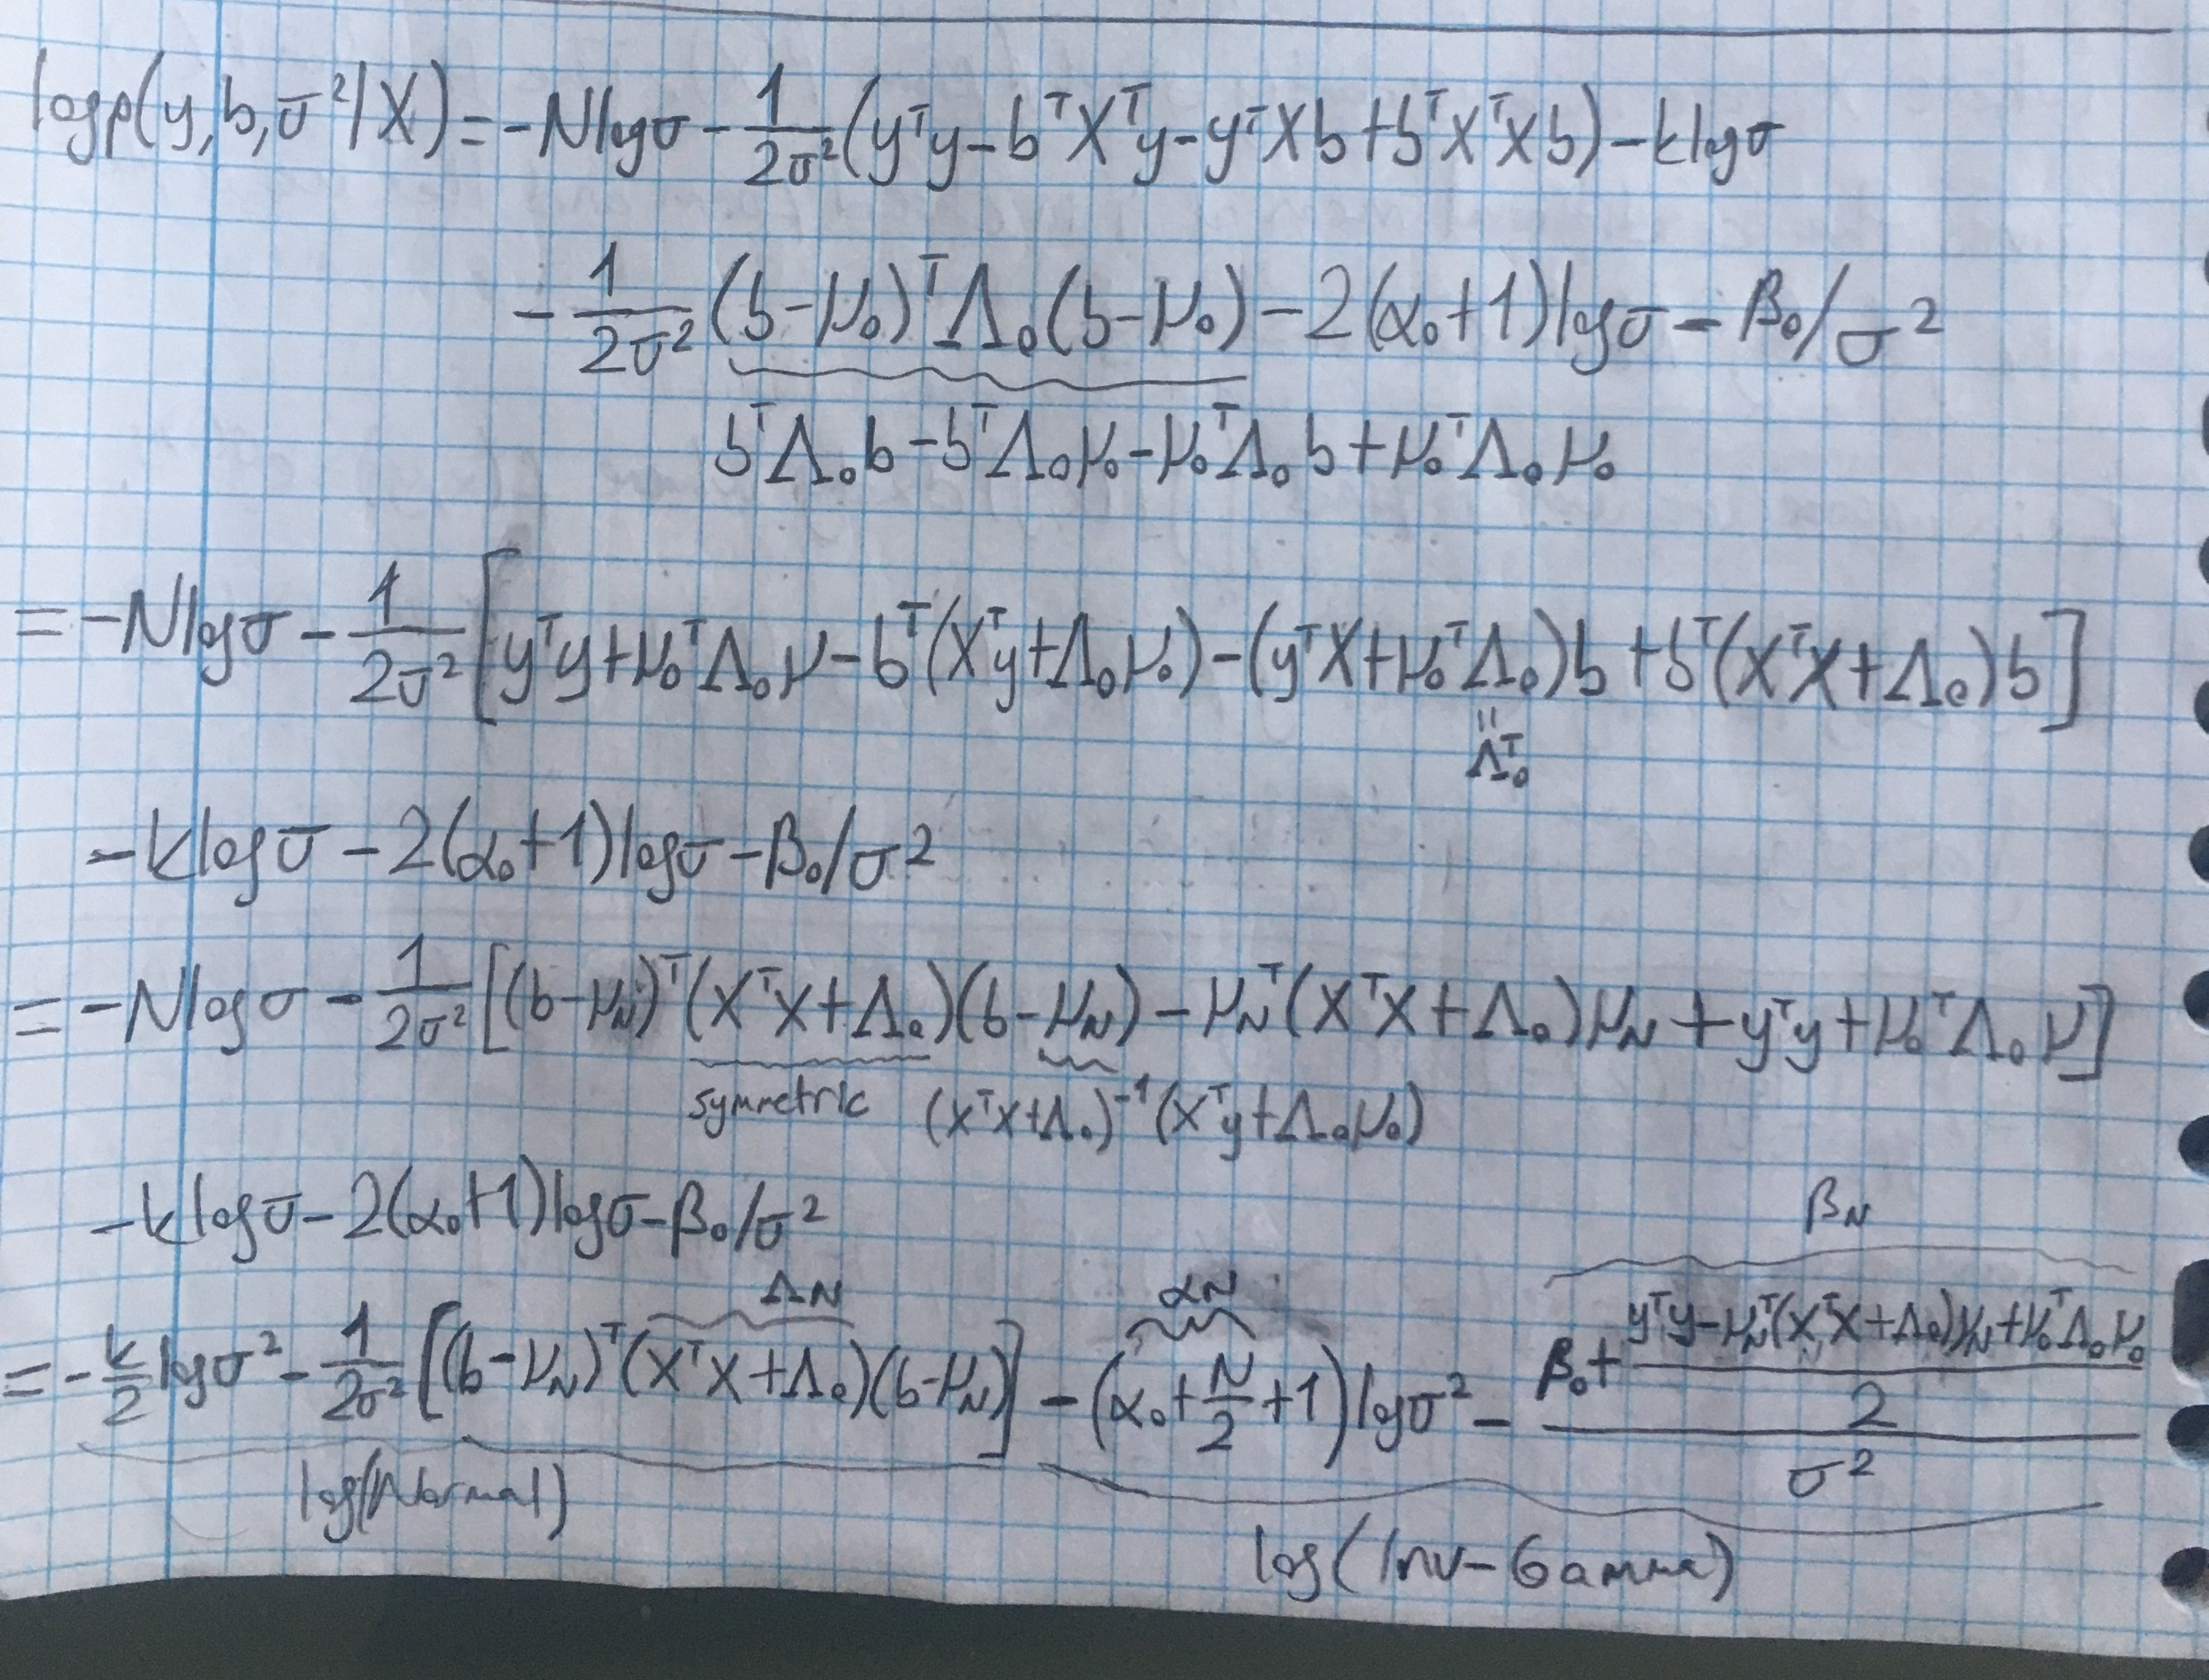

In [74]:
display("image/png", read("img/LR1.png"))

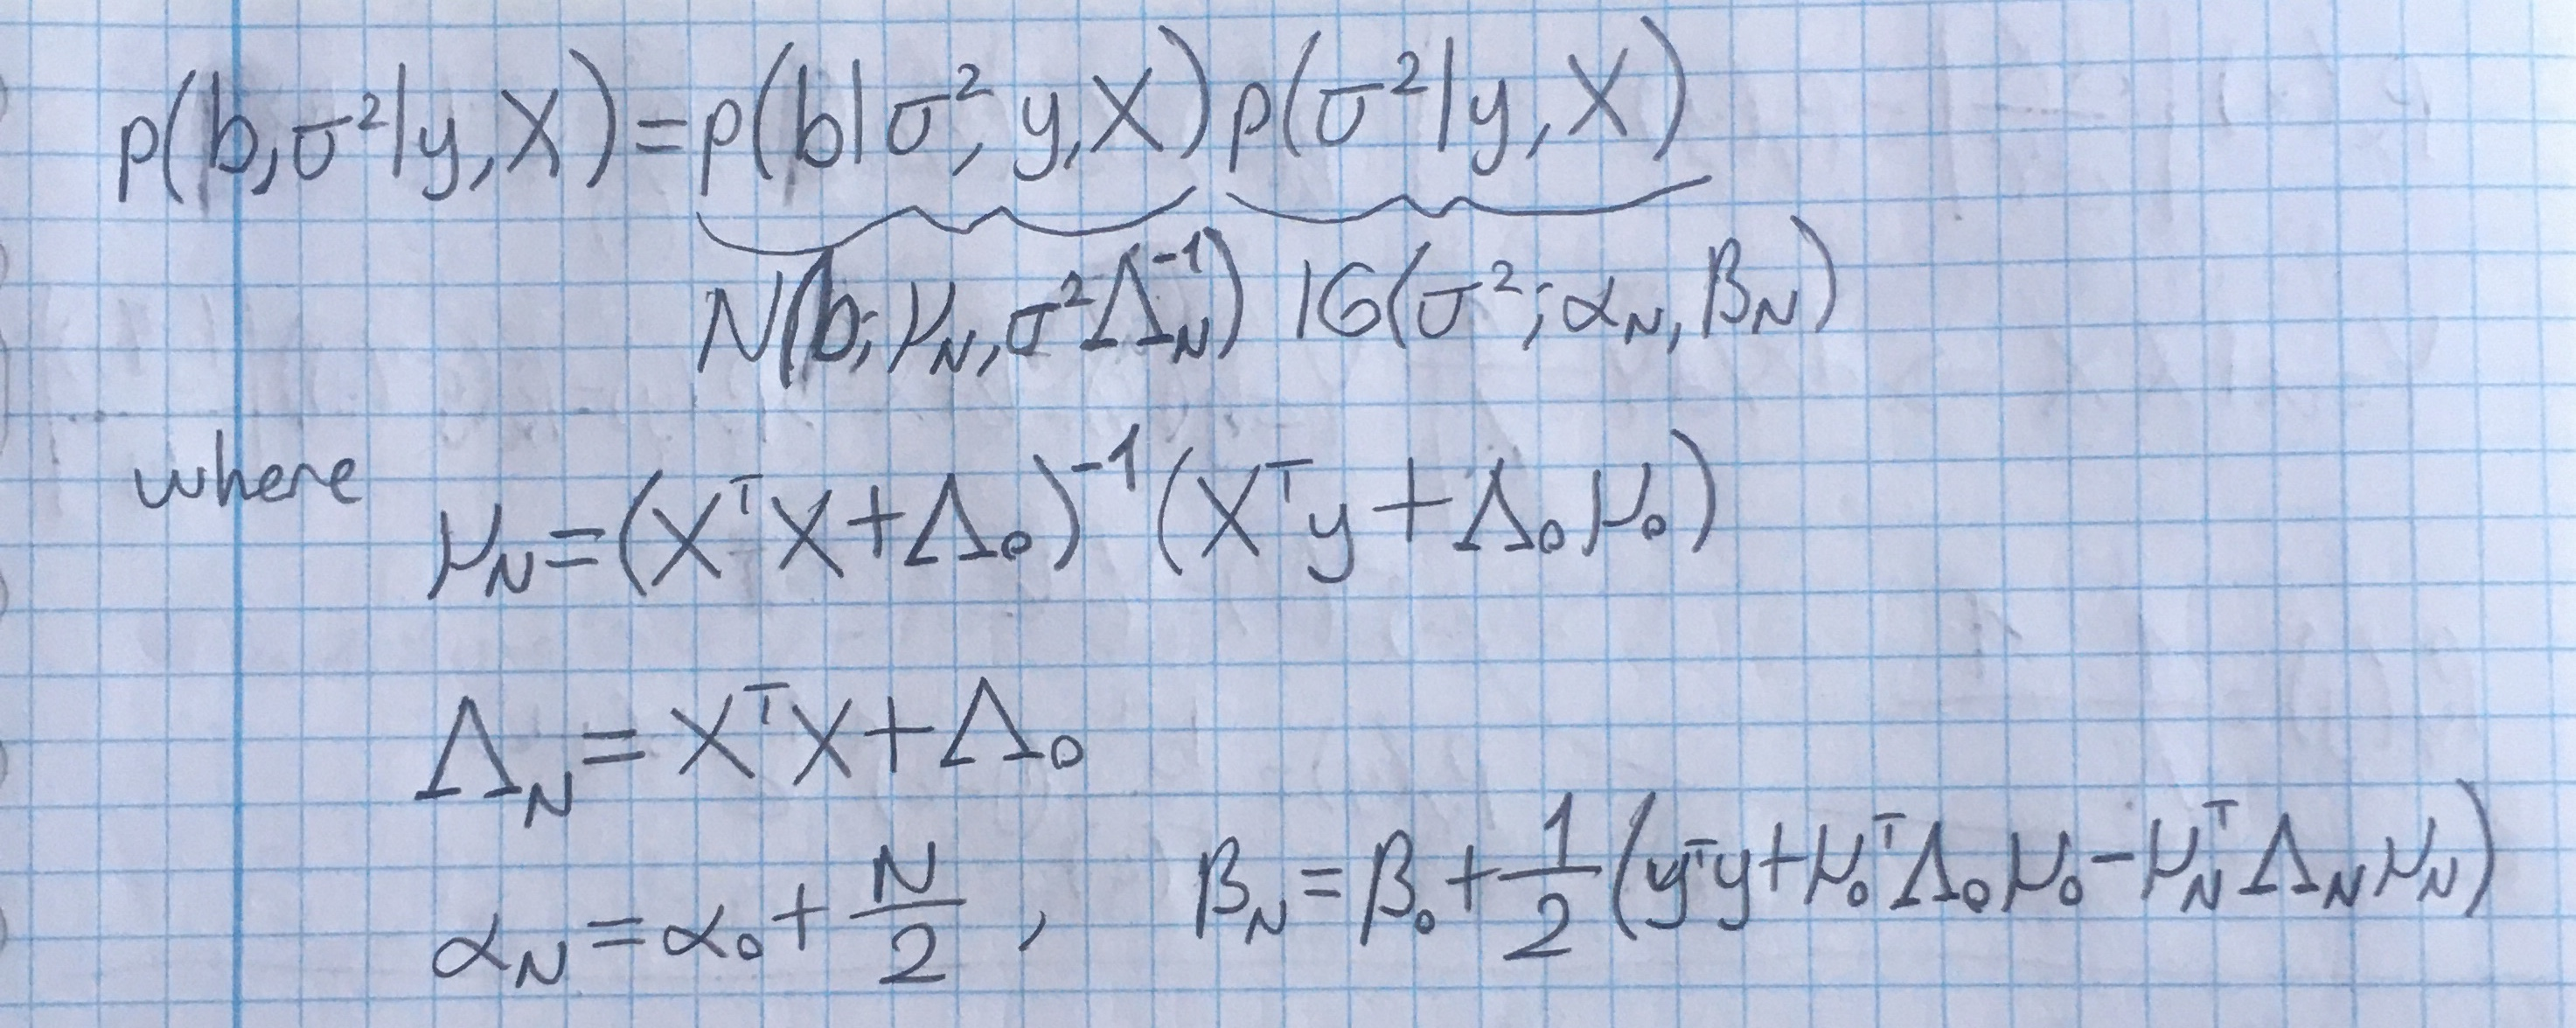

In [75]:
display("image/png", read("img/LR2.png"))

$p(b|y,X)$ can also be evaluated analytically by $\int p(b,\sigma^2|y,X) d\sigma^2$ which leads to student-t distribution.

### Posterior Predictive

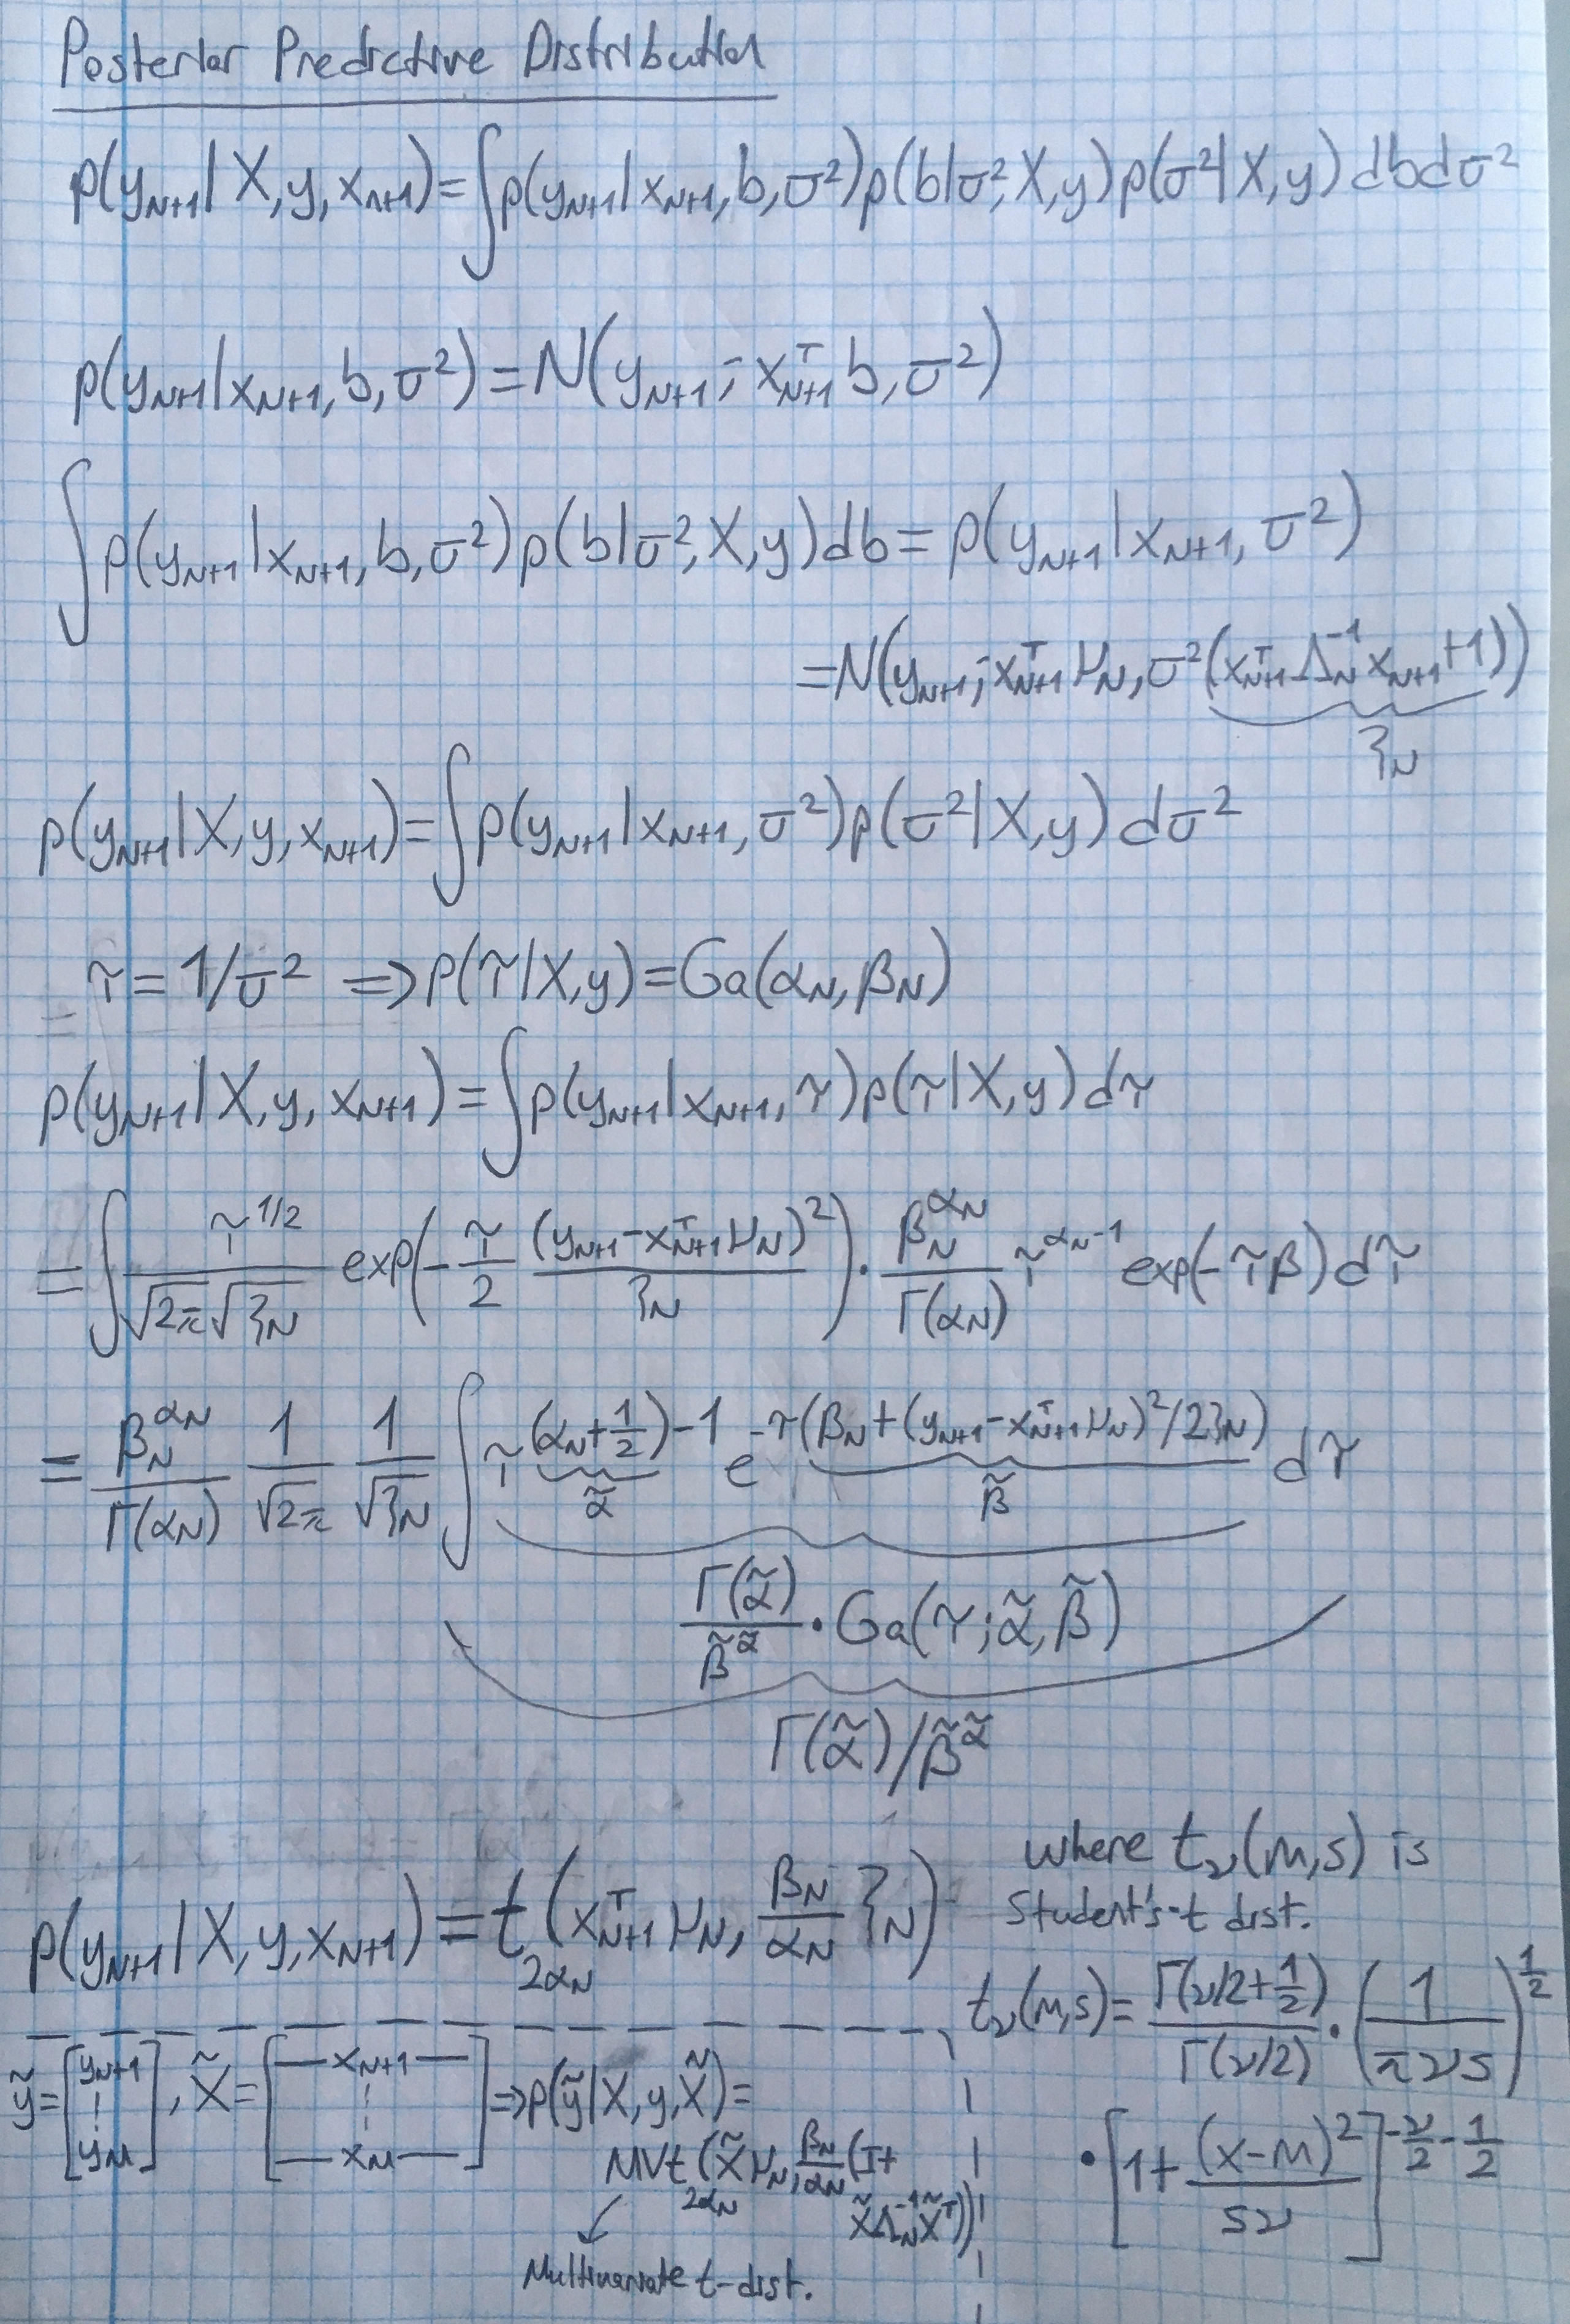

In [76]:
display("image/png", read("img/LR3.png"))

In [77]:
# Specify the prior parameters
μ_0, Λ_0 = zeros(13), diagm(0=>0.1*ones(13))
α_0, β_0 = 1, 1 #uninformative prior
;

In [78]:
# Evaluate posterior parameters
μ_N = (X_train'*X_train+Λ_0)\(X_train'*z_train+Λ_0*μ_0)
Λ_N = X_train'*X_train + Λ_0
α_N = α_0 + length(z_train)/2
β_N = β_0 + 0.5 * (z_train'*z_train + μ_0'*Λ_0*μ_0 - μ_N'*Λ_N*μ_N)
;

In [79]:
@show μ_N
@show Λ_N
@show α_N
@show β_N
;

μ_N = [-0.0192128, -0.0404642, 0.0108012, 0.164529, 0.023495, -0.755056, 0.702605, -0.116348, 0.828462, 0.382174, 0.00235772, 0.0360969, 0.0866967]
Λ_N = [24.1 0.0 0.0 0.0 0.0 0.0 0.0 8.17319 8.9007 13.0541 32.4885 13.1259 24.0; 0.0 16.1 0.0 0.0 0.0 0.0 0.0 -10.2628 -10.4228 -10.007 -9.28971 -8.55601 16.0; 0.0 0.0 5.1 0.0 0.0 0.0 0.0 0.9568 1.02683 0.967564 0.703635 2.11481 5.0; 0.0 0.0 0.0 9.1 0.0 0.0 0.0 -7.26852 -7.28766 -7.11576 -0.362441 -6.89893 9.0; 0.0 0.0 0.0 0.0 36.1 0.0 0.0 -4.43632 -4.44157 -8.11337 -12.0425 4.99577 36.0; 0.0 0.0 0.0 0.0 0.0 12.1 0.0 19.9648 19.5875 18.6001 -3.44405 5.23451 12.0; 0.0 0.0 0.0 0.0 0.0 0.0 9.1 -14.1247 -14.4537 -14.822 -14.3684 -16.9353 9.0; 8.17319 -10.2628 0.9568 -7.26852 -4.43632 19.9648 -14.1247 118.04 117.876 117.149 67.6634 100.251 -6.99752; 8.9007 -10.4228 1.02683 -7.28766 -4.44157 19.5875 -14.4537 117.876 118.014 117.358 69.2484 100.938 -7.09068; 13.0541 -10.007 0.967564 -7.11576 -8.11337 18.6001 -14.822 117.149 117.358 118.193 76.0732

In [80]:
# Calculate mean of predictions
z_mean_estimate = X_test*μ_N;

# Inverse mapping
y_mean_estimate = std(y_train).*z_mean_estimate .+ mean(y_train)

#calculate mean squared error over mean estimates
mse = sum((y_test.-y_mean_estimate).^2)/length(y_test)

7996.297347859295

In [81]:
# Quantitative comparisons
println("True test weights: ", y_test)
println("Estimated means for test weights: ", y_mean_estimate)

True test weights: [900.0, 685.0, 700.0, 950.0, 345.0, 90.0, 770.0, 80.0, 690.0, 500.0, 363.0, 130.0, 78.0, 250.0, 225.0, 120.0, 850.0, 300.0, 955.0, 7.0, 475.0, 32.0, 9.9, 150.0, 13.4, 145.0, 514.0, 700.0, 110.0, 130.0, 567.0, 170.0, 300.0, 290.0, 9.7, 10.0, 115.0, 200.0, 145.0, 135.0, 160.0, 820.0, 1100.0, 1100.0, 650.0, 390.0, 500.0, 540.0]
Estimated means for test weights: [866.001, 645.011, 610.005, 918.757, 490.561, 41.2076, 866.547, 30.1261, 742.373, 747.799, 443.109, 169.334, 13.7191, 377.8, 226.112, 100.328, 733.694, 446.327, 827.583, -52.6854, 531.136, -180.637, -4.16731, 187.788, 17.3758, 176.828, 569.425, 689.861, 153.681, 124.161, 780.286, 165.198, 359.401, 344.816, -35.442, -3.22067, 111.11, 206.67, 134.195, 149.978, 156.783, 824.913, 978.648, 938.854, 815.507, 487.002, 480.599, 525.586]
